In [47]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import torch.optim as optim

import os
import scipy.io as sio
import numpy as np
from collections import defaultdict
import pandas as pd

import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import random

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

We're using => cuda


In [14]:
class EmgMatDataset:
    """Create custom dataset from .mat files"""

    def __init__(self, path_of_root):
        path_check = os.listdir(path_of_root)
        assert len(path_check) != 0, "The path for data loader must not empty! Please check your path"
        self.root_path = path_of_root
        
    def matloader(self, variable_name):
        assert type(variable_name) == str, 'The name of MATLAB matrix must be a string'
        #create an empty dictionay with labels as the key
        dataset = []
        labelset = []
        root = sorted(os.listdir(self.root_path))
        for i in range(len(root)):
            train_path = self.root_path + root[i]
            for files in sorted(os.listdir(train_path)):
                EMG = sio.loadmat(train_path + '/' + files)
                data = EMG[variable_name]
                tensor = torch.from_numpy(data)
                dataset.append(tensor)
                labelset.append(root[i])
        
        return zip(labelset, dataset)

In [15]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()

        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32 * 4 * 4, 10)

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max pool 1
        out = self.maxpool1(out)

        # Convolution 2
        out = self.cnn2(out)
        out = self.relu2(out)

        # Max pool 2
        out = self.maxpool2(out)

        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)

        return out

In [ ]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [22]:
def get_class_distribution(dataset_obj):
    label = [1, 2, 3, 4, 5]
    count_dict = {key: 0 for key in label}
    for label_id, _ in dataset_obj:
        count_dict[int(label_id)] += 1
    return count_dict


def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)

### Load the train dataset

Text(0.5, 1.0, 'Train Dataset')

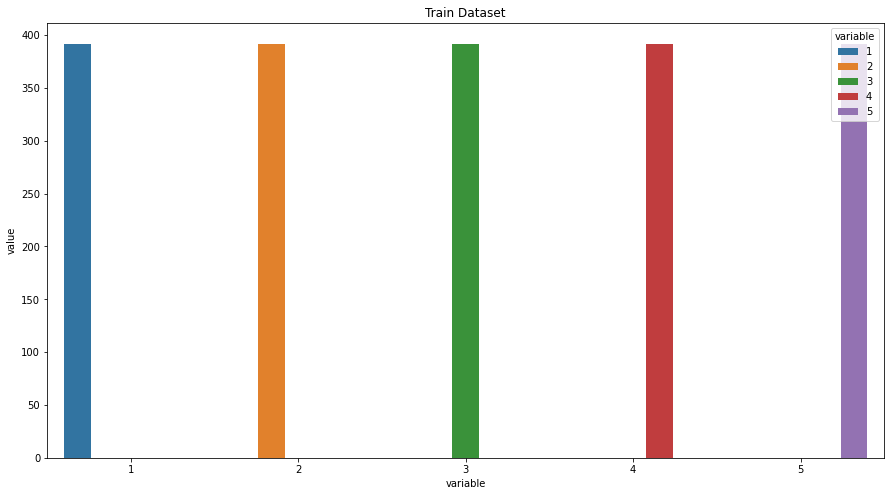

In [72]:
path1 = '/home/jerry/ghworkspace/EMG_CNN_TORCH/utils/mat/train/'
loader = EmgMatDataset(path1)
train = loader.matloader('sampleEMG')
train_loader = loader.matloader('sampleEMG')
train_loader = zip(*train_loader)
train_loader = list(train_loader)[1]
plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(train), plot_title="Train Dataset")

## Load the test dataset

Text(0.5, 1.0, 'Test Dataset')

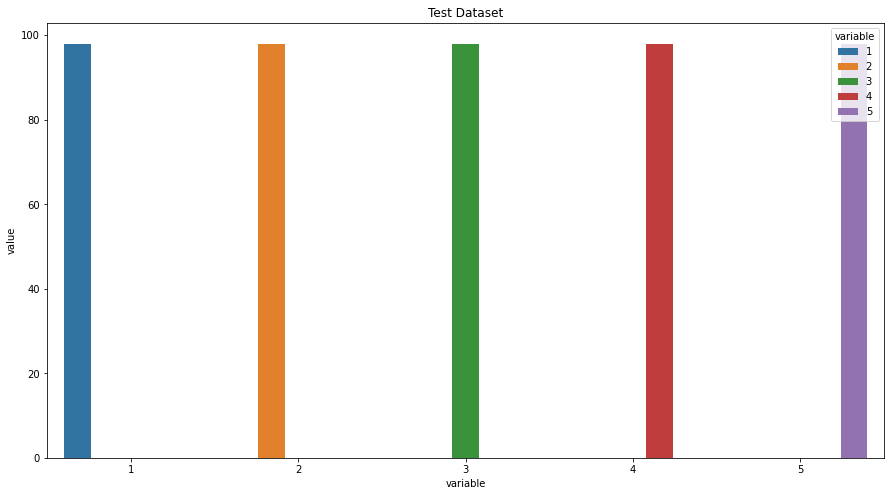

In [73]:
path1 = '/home/jerry/ghworkspace/EMG_CNN_TORCH/utils/mat/test/'
loader = EmgMatDataset(path1)
test = loader.matloader('sampleEMG')
test_loader = loader.matloader('sampleEMG')
test_loader = zip(*test_loader)
test_loader = list(test_loader)[1]
plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(test), plot_title="Test Dataset")

## Load the validation dataset

Text(0.5, 1.0, 'Validation Dataset')

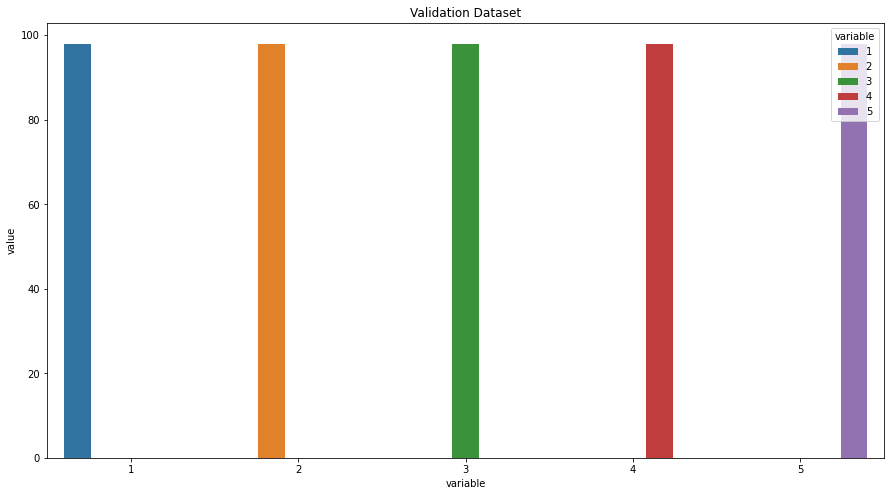

In [74]:
path1 = '/home/jerry/ghworkspace/EMG_CNN_TORCH/utils/mat/val/'
loader = EmgMatDataset(path1)
val = loader.matloader('sampleEMG')
val_loader = loader.matloader('sampleEMG')
val_loader = zip(*val_loader)
val_loader = list(val_loader)[1]
plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(val), plot_title="Validation Dataset")

In [44]:
model = CNNModel()
model.to(device)
print(model)

CNNModel(
  (cnn1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)


In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [50]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [76]:
print("Begin training.")

for e in tqdm(range(1, 11)):
    
    # TRAINING
    
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for Y_train_batch, X_train_batch in train:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch).squeeze()
                
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for Y_val_batch, X_val_batch in val:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch).squeeze()
            
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
                                    
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()

    
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 01: | Train Loss: 0.00000 | Val Loss: 0.00000 | Train Acc: 0.000| Val Acc: 0.000
Epoch 02: | Train Loss: 0.00000 | Val Loss: 0.00000 | Train Acc: 0.000| Val Acc: 0.000
Epoch 03: | Train Loss: 0.00000 | Val Loss: 0.00000 | Train Acc: 0.000| Val Acc: 0.000
Epoch 04: | Train Loss: 0.00000 | Val Loss: 0.00000 | Train Acc: 0.000| Val Acc: 0.000
Epoch 05: | Train Loss: 0.00000 | Val Loss: 0.00000 | Train Acc: 0.000| Val Acc: 0.000
Epoch 06: | Train Loss: 0.00000 | Val Loss: 0.00000 | Train Acc: 0.000| Val Acc: 0.000
Epoch 07: | Train Loss: 0.00000 | Val Loss: 0.00000 | Train Acc: 0.000| Val Acc: 0.000
Epoch 08: | Train Loss: 0.00000 | Val Loss: 0.00000 | Train Acc: 0.000| Val Acc: 0.000
Epoch 09: | Train Loss: 0.00000 | Val Loss: 0.00000 | Train Acc: 0.000| Val Acc: 0.000
Epoch 10: | Train Loss: 0.00000 | Val Loss: 0.00000 | Train Acc: 0.000| Val Acc: 0.000


In [54]:
print(unlis)

[]
